# Uwagi

- transformer_3 nie dzialal poprawnie na danych ktorych nie widział. Pojawił się problem z onehot codingiem, ponieważ w zbiorze walidatorskim pojawily sie nowe wartosci kolumny OS
- brak ustawionego random seed w modelu - nie jest on powtarzalny i daje rozne wyniki metryk po kilkukrotnym odpaleniu

# Wnioski

- Modelarze nie uzględnili możliwości pojawienia się nowych wartości w kolumnach które one hot encodują. Na co zwróciliśmy im uwagę.
- brak ustawionego random seed w modelu - nie jest on powtarzalny i daje rozne wyniki metryk oraz numery klastrów 
po kilkukrotnym uruchomieniu
- ogólne charakterystyki klastrów zaproponowane przez modelarzy działają również na zbiorze walidacyjnym
- wyniki metryk na zbiorze walidacyjnym i modelarskim są porównywalne
- Według mnie model dobrze sobie radzi z podziałem danych i stworzone klastry mają sens w kontekscie biznesowym

# Testy

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import cluster, datasets, mixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN
from sklearn.manifold import TSNE

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline
from functools import partial

C:\Users\bartekb\AppData\Local\Temp\ipykernel_31288\1629838151.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [40]:
class MinMaxTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,classes):
         self.scaler = [MinMaxScaler() for _ in range(len(classes))]
         self.classes = classes
         
    def fit(self, X, y=None):
            for i,col in enumerate(self.classes):
                self.scaler[i].fit(X[[col]])
            return self
    
    def transform(self, X, y=None):
        Xc = X.copy()
        for i,col in enumerate(self.classes):
             Xc[col] = self.scaler[i].transform(Xc[[col]])
        return Xc

class transformer_3(BaseEstimator, TransformerMixin):
    
    def fit(self,df,y= None):
        return self
    
    def transform(self,X,y= None):
    
        X_copy = X.copy()

        # Resolution correction
        mask = X_copy.resolution_width <= X_copy.resolution_height
        X_copy.loc[mask,["resolution_width","resolution_height"]] = X_copy.loc[mask,["resolution_height","resolution_width"]].values

        # Processor tier
        new_column=X_copy['processor_tier'].str.extract(r'(\d)')
        new_column=new_column.fillna(0)
        X_copy['processor_tier']=new_column

        # Poprawa walidatorska
        test_os = ['windows' 'dos' 'mac' 'chrome' 'other']
        X_copy['OS'] = X_copy['OS'].apply(lambda x: x if x in test_os else 'other')

        # One Hot Encoding
        diff1 = pd.get_dummies(X_copy[['processor_brand','OS','gpu_brand','gpu_type']],dtype='int')


        # OHEncoding brands
        brands_to_keep = ['hp' , 'lenovo' , 'asus','dell','msi','acer','apple']
        X_copy['brand'] = X_copy['brand'].apply(lambda x: x if x in brands_to_keep else 'other')
        diff2 = pd.get_dummies(X_copy[['brand']],dtype='int')
        X_copy = pd.concat([X_copy,diff1,diff2],axis=1)
        X_copy = X_copy.drop(['index','Model','brand','OS','processor_brand','gpu_brand','gpu_type'],axis=1)

        # Correcting types
        X_copy.is_touch_screen = X_copy.is_touch_screen + 0
        X_copy.primary_storage_type = (X_copy.primary_storage_type=='SSD') + 0

        # Price to log
        X_copy['Price'] = np.log(X_copy['Price'] )

        # year_of_warranty
        mask_year_of_war_no =X_copy.year_of_warranty=='No information'
        X_copy.loc[mask_year_of_war_no,['year_of_warranty']] = 0
        X_copy['year_of_warranty'] = X_copy['year_of_warranty'].apply(lambda x : int(x))
        X_copy['year_of_warranty_other'] = mask_year_of_war_no + 0

        # secondary_storage_type drop
        X_copy = X_copy.drop('secondary_storage_type',axis=1)

        # other transformations 
        X_copy['primary_storage_capacity'] = np.log2(X_copy.primary_storage_capacity)
        X_copy['secondary_storage_capacity'] = X_copy['secondary_storage_capacity'].apply(lambda x : max(0,np.log2(x)))
        X_copy['resolution_width']  = np.log(X_copy.resolution_width)
        X_copy['resolution_height'] = np.log(X_copy.resolution_height) 
        X_copy['Rating'] = X_copy['Rating']/100

        # for i,col in enumerate(self.classes):
        #     X_copy[col] = self.minmax[i].fit_transform(X_copy[[col]])
        

        return X_copy

In [102]:
classess = ['Price','resolution_width','resolution_height','display_size','processor_tier','num_cores','num_threads',
            'ram_memory','primary_storage_capacity','secondary_storage_capacity']

gmm_model = mixture.GaussianMixture(n_components=4,
                                     covariance_type='tied',
                                     tol=1e-05,
                                     reg_covar=1e-06) # podalem random seeda
                                    

ppl = Pipeline([('transformer',transformer_3()),('minmax',MinMaxTransformer(classess))])

In [48]:
data_modelers = pd.read_csv('../../data/modelers_data.csv')
data_validate = pd.read_csv('../../data/validators_data.csv')

In [49]:
print(data_validate['OS'].unique())
print(data_modelers['OS'].unique())

['mac' 'windows' 'dos' 'android' 'other' 'chrome' 'ubuntu']
['windows' 'dos' 'mac' 'chrome' 'other']


In [50]:
train_data = ppl.fit_transform(data_modelers)
test_data = ppl.fit_transform(data_validate)
gmm_model.fit(train_data)
test_clusters = gmm_model.predict(test_data)

C:\Users\bartekb\AppData\Local\Temp\ipykernel_31288\1600958714.py:68: RuntimeWarning: divide by zero encountered in log2
  X_copy['secondary_storage_capacity'] = X_copy['secondary_storage_capacity'].apply(lambda x : max(0,np.log2(x)))
C:\Users\bartekb\AppData\Local\Temp\ipykernel_31288\1600958714.py:68: RuntimeWarning: divide by zero encountered in log2
  X_copy['secondary_storage_capacity'] = X_copy['secondary_storage_capacity'].apply(lambda x : max(0,np.log2(x)))


In [51]:
data_validate['cluster'] = test_clusters

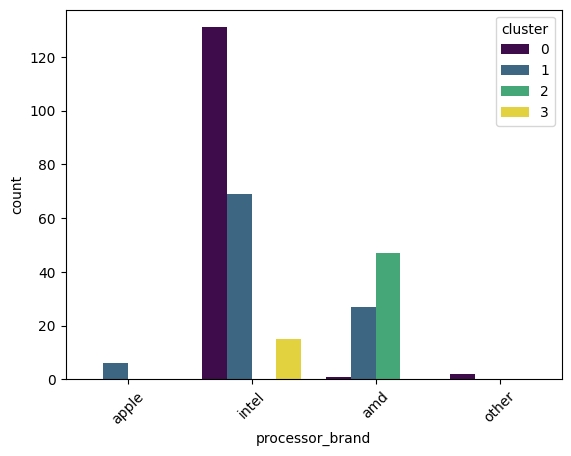

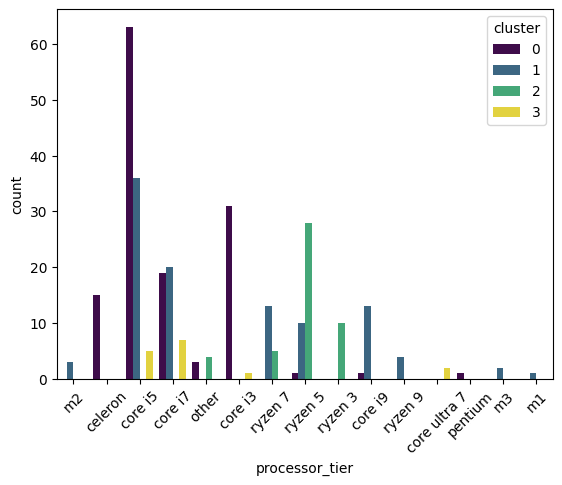

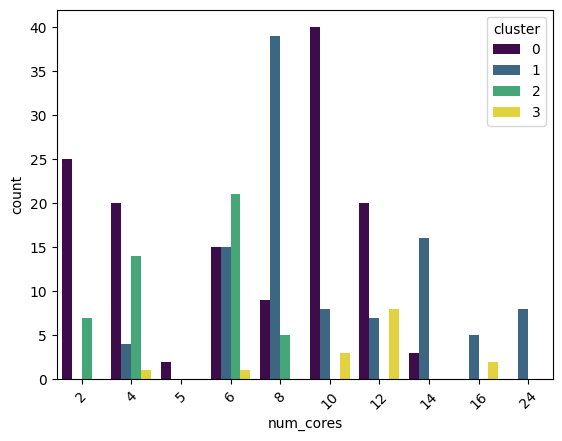

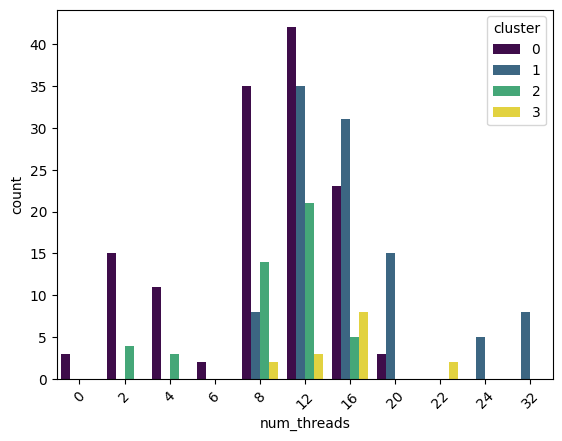

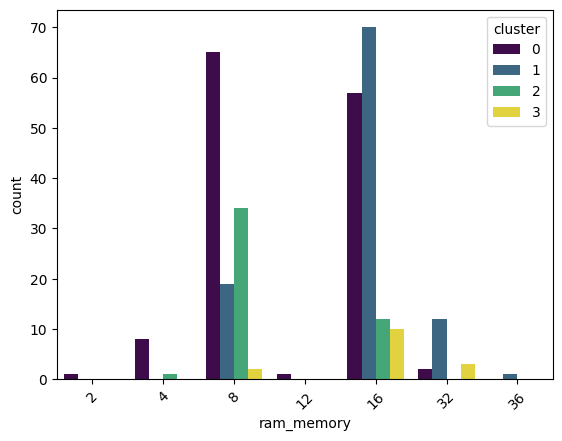

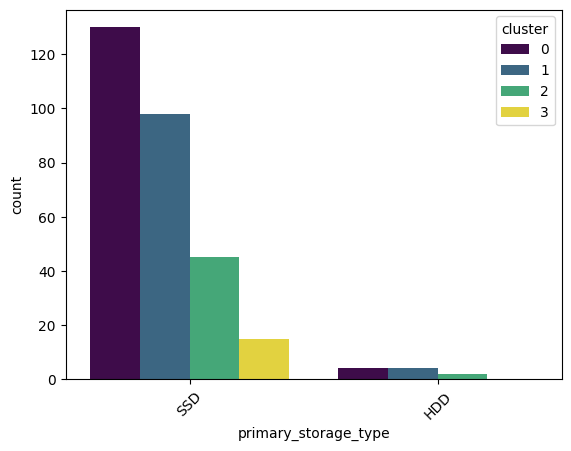

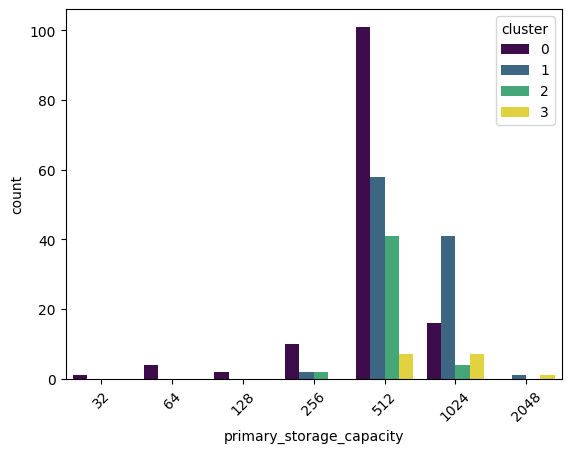

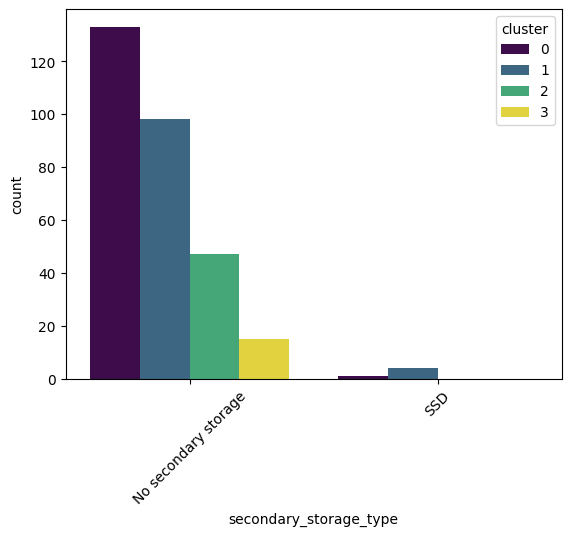

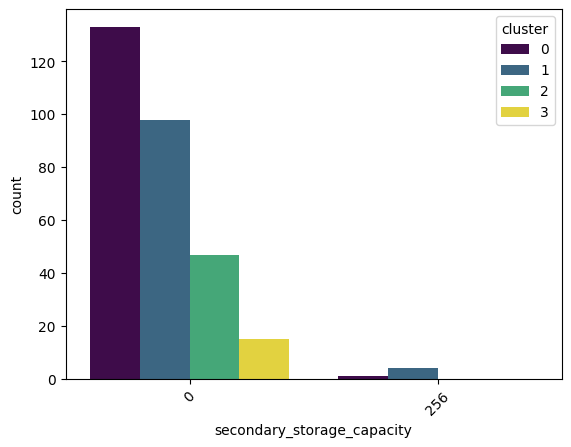

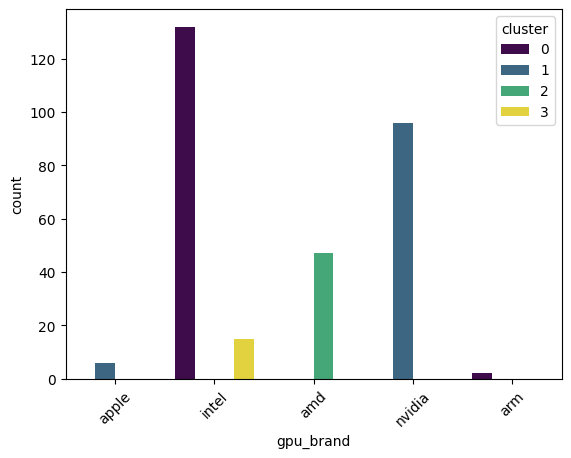

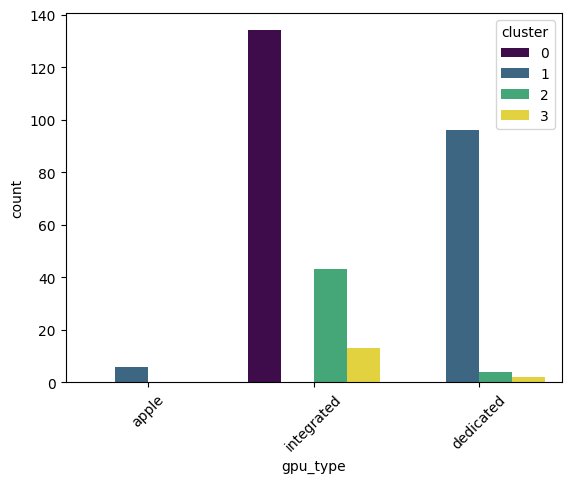

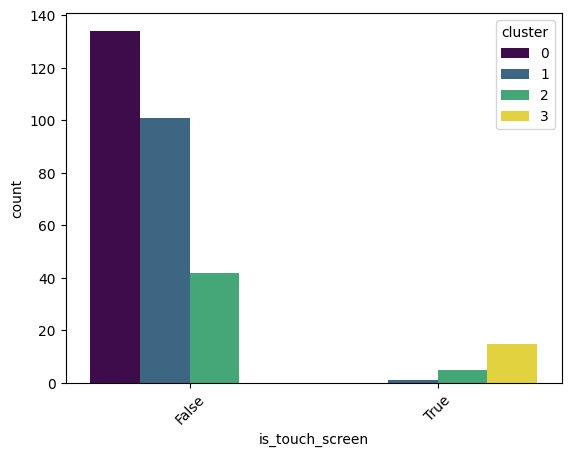

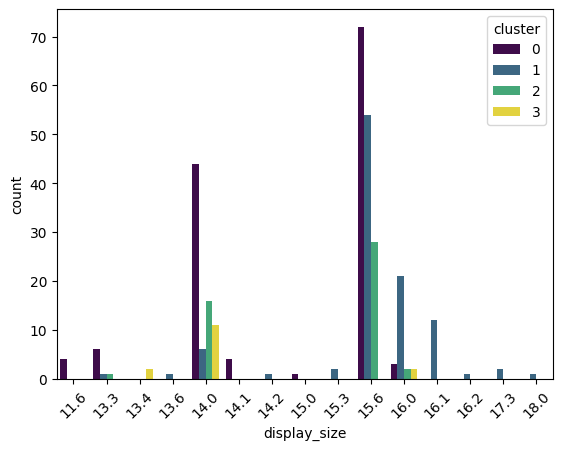

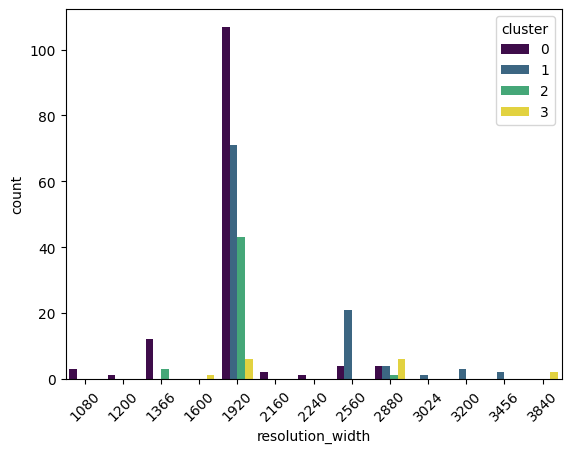

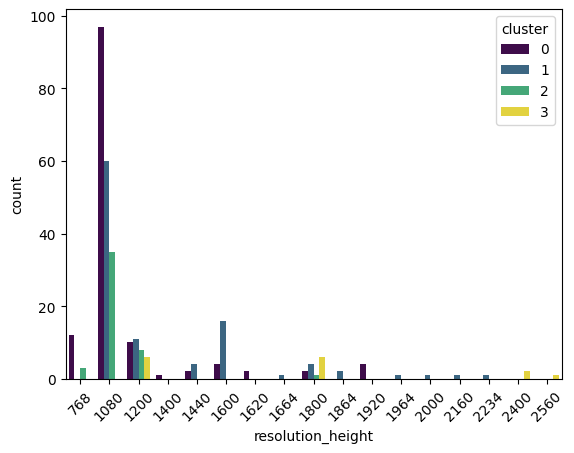

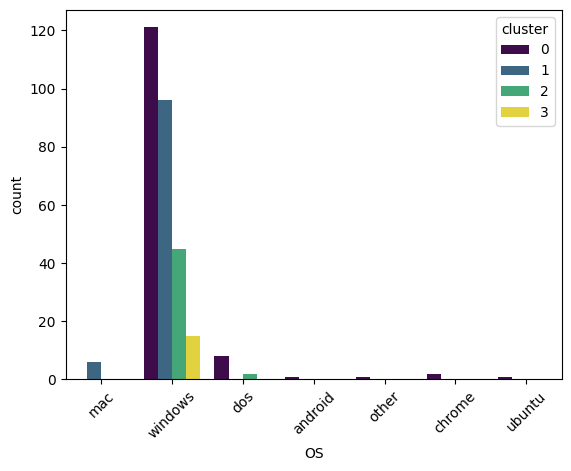

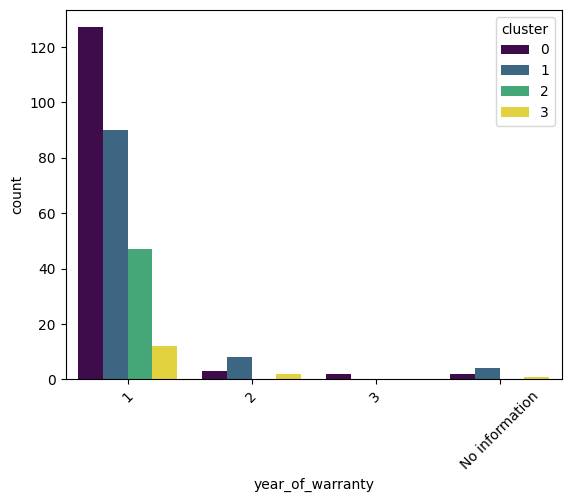

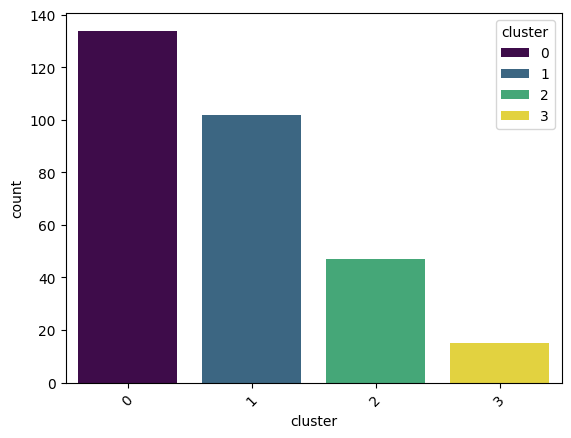

In [54]:
# take columns with less unique values than 20
discrete_columns=[]
for col in data_validate.columns:
    if len(data_validate[col].unique())<20:
        discrete_columns.append(col)
        
for col in discrete_columns:
    sns.countplot(data=data_validate,x=col,hue='cluster',palette='viridis')
    plt.xticks(rotation=45)
    plt.show()

In [58]:
def show_metrics(X,model):
    # input:
    # X = przetransformowany dataFrame
    # model = niewytrenowany model
    X = X.values
    y = model.fit_predict(X)
    silhouette = silhouette_score(X, y)
    db_index = davies_bouldin_score(X, y)
    ch_index = calinski_harabasz_score(X, y)  

    return([silhouette,db_index,ch_index])
def pca_visualization(df,clusters):
    pca = PCA(n_components=2)  
    X_pca = pca.fit_transform(df)
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],hue=clusters, palette='tab20', legend='full')
    plt.title('K-means Clustering (PCA Visualization)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()
def pca_3d(df,clusters):
    pca = PCA(n_components=3)  

    X_pca = pca.fit_transform(df)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=clusters, cmap='tab20')

    ax.set_title('K-means Clustering (3D PCA Visualization)')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    legend1 = ax.legend(*scatter.legend_elements(), title='Clusters')
    ax.add_artist(legend1)

    plt.show()
def tsne_visualization(dataframe, predicted_clusters):
    tsne = TSNE(n_components=2, random_state=69)
    tsne_results = tsne.fit_transform(dataframe)
    tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
    tsne_df['Cluster'] = predicted_clusters
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x='TSNE1', y='TSNE2',
        hue='Cluster',
        palette=sns.color_palette('hsv', len(set(predicted_clusters))),
        data=tsne_df,
        legend='full',
        alpha=0.7
    )
    plt.title('t-SNE Visualization of Clusters')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Cluster')
    plt.show()

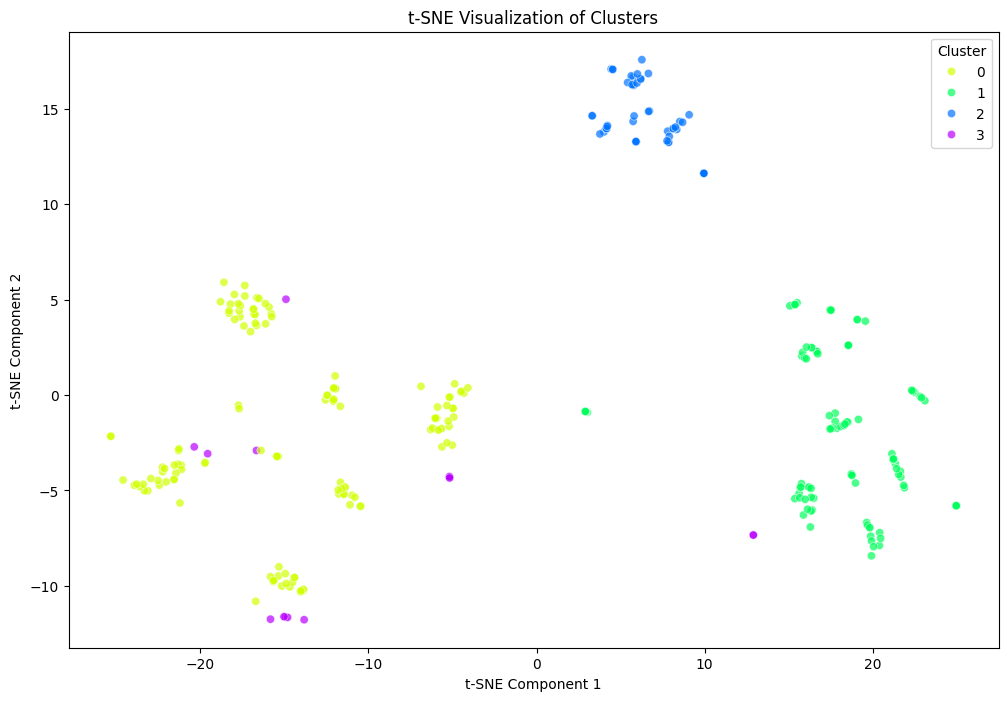

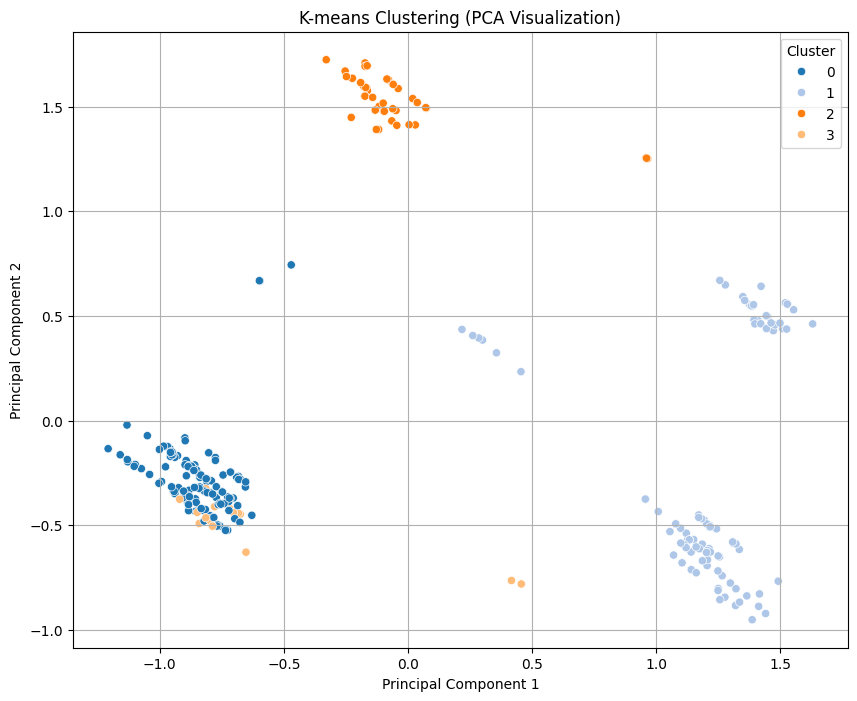

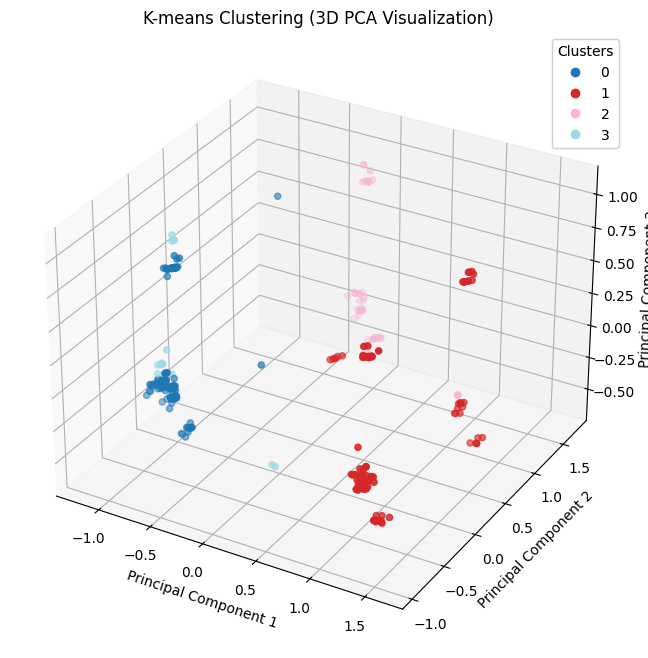

In [60]:
tsne_visualization(test_data,test_clusters)
pca_visualization(test_data,test_clusters)
pca_3d(test_data,test_clusters)

# Walidacja metryk

brak random seeda powoduje ze otrzymujemy rozne wyniki za kazdym razem. Wyniki na zbiorze tesstowym i walidacyjnym są porównywalne

In [96]:
print('wyniki na zbiorze modelarzy')
print(show_metrics(train_data,gmm_model))
print("wyniki na zbiorze walidacyjnym")
print(show_metrics(test_data,gmm_model))

wyniki na zbiorze modelarzy
[0.2601610835768208, 1.3624322002919595, 229.87582114504087]
wyniki na zbiorze walidacyjnym
[0.2566354784590417, 1.4581895885567382, 91.88483418057305]


In [97]:
print('wyniki na zbiorze modelarzy')
print(show_metrics(train_data,gmm_model))
print("wyniki na zbiorze walidacyjnym")
print(show_metrics(test_data,gmm_model))

wyniki na zbiorze modelarzy
[0.337684376175161, 1.3198294321530062, 248.8436774180764]
wyniki na zbiorze walidacyjnym
[0.22548371518692253, 1.3571385804812415, 90.53885175770284]


In [98]:
print('wyniki na zbiorze modelarzy')
print(show_metrics(train_data,gmm_model))
print("wyniki na zbiorze walidacyjnym")
print(show_metrics(test_data,gmm_model))

wyniki na zbiorze modelarzy
[0.3372763398880458, 1.344479407787426, 249.47344995267295]
wyniki na zbiorze walidacyjnym
[0.23036603380470036, 1.3336148534092727, 91.40969880581902]


# Walidacja interpretacji klastrów

In [109]:
# Pokrywa się z interpretacją podaną przez modelarzy - ale do klastra 3
data_validate[data_validate.cluster == 0].head()

,index,brand,Model,Price,Rating,processor_brand,processor_tier,num_cores,num_threads,ram_memory,...,secondary_storage_capacity,gpu_brand,gpu_type,is_touch_screen,display_size,resolution_width,resolution_height,OS,year_of_warranty,cluster
1,343,avita,Avita Pura S102 Laptop (Celeron N4020/ 8GB/ 51...,20999,43,intel,celeron,2,2,8,...,0,intel,integrated,False,15.6,1920,1080,windows,1,0
2,513,lenovo,Lenovo V15 G3 IAP 82TT004VIH Laptop (12th Gen ...,45490,56,intel,core i5,10,12,8,...,0,intel,integrated,False,15.6,1920,1080,dos,1,0
3,321,hp,HP 250 G9 95X40PA Laptop (12th Gen Core i7/ 8G...,67288,52,intel,core i7,10,12,8,...,0,intel,integrated,False,15.6,1920,1080,dos,1,0
4,94,ultimus,Ultimus Pro NU14U3INC43BN-CS Laptop (Celeron N...,11990,41,intel,celeron,2,2,4,...,0,intel,integrated,False,14.1,1366,768,windows,1,0
5,547,lenovo,Lenovo IdeaPad Slim 5i 82XD0040IN Laptop (13th...,86990,62,intel,core i7,10,16,16,...,0,intel,integrated,False,14.0,1920,1200,windows,1,0


In [101]:
# Pokrywa się z interpretacją podaną przez modelarzy - ale do klastra 0
data_validate[data_validate.cluster == 1].head()

,index,brand,Model,Price,Rating,processor_brand,processor_tier,num_cores,num_threads,ram_memory,...,secondary_storage_capacity,gpu_brand,gpu_type,is_touch_screen,display_size,resolution_width,resolution_height,OS,year_of_warranty,cluster
0,224,apple,Apple MacBook Air 15 2023 Laptop (Apple M2/ 8G...,144990,56,apple,m2,8,8,8,...,0,apple,apple,False,15.3,2880,1864,mac,1,1
7,115,asus,Asus Vivobook 14X K3405ZFB-KM752WS Laptop (12t...,85990,75,intel,core i7,10,16,16,...,0,nvidia,dedicated,False,14.0,2880,1800,windows,1,1
10,371,lenovo,Lenovo IdeaPad Gaming 3 15IHU6 82K101R9IN Lapt...,55700,69,intel,core i5,4,8,8,...,0,nvidia,dedicated,False,15.6,1920,1080,windows,1,1
13,102,asus,Asus ROG Strix G16 2023 G614JJ-N3086WS Gaming ...,94990,70,intel,core i5,10,16,16,...,0,nvidia,dedicated,False,16.0,1920,1200,windows,1,1
22,722,msi,MSI Bravo 15 C7VEK-088IN Gaming Laptop (AMD Ry...,94990,77,amd,ryzen 7,8,16,16,...,0,nvidia,dedicated,False,15.6,1920,1080,windows,1,1


In [103]:
# Pokrywa się z interpretacją podaną przez modelarzy
data_validate[data_validate.cluster == 2].head()

,index,brand,Model,Price,Rating,processor_brand,processor_tier,num_cores,num_threads,ram_memory,...,secondary_storage_capacity,gpu_brand,gpu_type,is_touch_screen,display_size,resolution_width,resolution_height,OS,year_of_warranty,cluster
6,291,hp,HP 247 G8 67U77PA Laptop (Athlon P-3045B HD/ 8...,24990,52,amd,other,2,2,8,...,0,amd,integrated,False,14.0,1366,768,windows,1,2
11,457,lenovo,Lenovo Yoga 6 13ABR8 83B2007UIN Laptop (AMD Ry...,86990,71,amd,ryzen 7,8,16,16,...,0,amd,integrated,True,13.3,1920,1200,windows,1,2
16,876,asus,Asus Vivobook Go 15 OLED 2023 E1504FA-LK545WS ...,58990,60,amd,ryzen 5,4,8,16,...,0,amd,integrated,False,15.6,1920,1080,windows,1,2
17,945,lenovo,Lenovo V15 G2 82KDA022IH Laptop (AMD Ryzen 5 5...,35890,56,amd,ryzen 5,6,12,8,...,0,amd,integrated,False,15.6,1920,1080,windows,1,2
19,838,hp,HP 15s-eq1580AU Laptop (AMD Ryzen 3 3250U/ 8GB...,32990,58,amd,ryzen 3,2,4,8,...,0,amd,integrated,False,15.6,1920,1080,windows,1,2


In [111]:
# Pokrywa się z interpretacją podaną przez modelarzy - ale do klastra 1
data_validate[data_validate.cluster == 3].head()

,index,brand,Model,Price,Rating,processor_brand,processor_tier,num_cores,num_threads,ram_memory,...,secondary_storage_capacity,gpu_brand,gpu_type,is_touch_screen,display_size,resolution_width,resolution_height,OS,year_of_warranty,cluster
26,886,msi,MSI Summit E13 Flip Evo A11MT-213IN Laptop (11...,81990,65,intel,core i7,4,8,16,...,0,intel,integrated,True,13.4,1920,1200,windows,2,3
27,530,fujitsu,Fujitsu UH-X 4ZR1L73352 2-in-1 Laptop (13th Ge...,109990,76,intel,core i7,12,16,16,...,0,intel,integrated,True,14.0,1920,1200,windows,2,3
48,733,dell,Dell XPS 13 Plus 9320 2023 Laptop (13th Gen Co...,201990,82,intel,core i7,12,16,32,...,0,intel,integrated,True,13.4,3840,2400,windows,1,3
57,374,lenovo,Lenovo Yoga 7 82YL0095IN Laptop (13th Gen Core...,92190,75,intel,core i5,12,16,16,...,0,intel,integrated,True,14.0,2880,1800,windows,1,3
62,927,asus,Asus Zenbook 14 Flip OLED 2023 UP3404VA-KN753W...,129990,74,intel,core i7,12,16,16,...,0,intel,integrated,True,14.0,2880,1800,windows,1,3
